In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

# Function load dataset
* Load table, then formatting each as same as main format

In [ ]:
def preprocess_dataset(input_path: str, sep: str, select_columns: list, rename_columns: list):
    if input_path.split(".")[1] == "txt":
        df = pd.read_csv(input_path, sep=sep, quoting=csv.QUOTE_NONE)
    elif input_path.split(".")[1] == "parquet":
        df = pd.read_parquet(input_path)
    else:
        df = pd.read_csv(input_path, sep=sep)

    if len(select_columns) == 0:
        return df
    elif len(rename_columns) == 0:
        return df[select_columns]
    elif len(select_columns) == len(rename_columns):
        for i in range(0, len(select_columns)):
            df.rename(columns={select_columns[i]: rename_columns[i]}, inplace=True)
        return df[rename_columns]
    else:
        return df

# Process data

## Process training set

In [ ]:
dataset_etpc = "./datasets/train_set/etpc_train.parquet"
dataset_mrpc = "./datasets/train_set/mrpc_train.parquet"
dataset_paws = "./datasets/train_set/paws_labeled_final_train.parquet"
dataset_superGlue = "./datasets/train_set/superGlue_axb_train.parquet"

In [ ]:
df_etpc = preprocess_dataset(dataset_etpc, "", ["sentence1", "sentence2", "etpc_label"], ["#1 String", "#2 String", "label"])
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])
df_superGlue = preprocess_dataset(dataset_superGlue, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])

df_train = pd.concat([df_etpc, df_paws, df_superGlue, df_mrpc])
df_train_quality = df_train.loc[df_train["label"] == 1]

## Process validation set

In [ ]:
dataset_mrpc = "./datasets/validation_set/mrpc_validation.parquet"
dataset_paws = "./datasets/validation_set/paws_labeled_final_validation.parquet"

In [ ]:
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])

df_validation = pd.concat([df_paws, df_mrpc])

## Process test set

In [ ]:
dataset_mrpc = "./datasets/test_set/mrpc_test.parquet"
dataset_paws = "./datasets/test_set/paws_labeled_final_test.parquet"
dataset_superGlue = "./datasets/test_set/superGlue_axg_test.parquet"

In [ ]:
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])
df_superGlue = preprocess_dataset(dataset_superGlue, "", ["premise", "hypothesis", "label"], ["#1 String", "#2 String", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["#1 String", "#2 String", "label"])

In [ ]:
df_testSet = pd.concat([df_paws, df_superGlue, df_mrpc])

# Analyse Dataset

In [ ]:
!pip install transformers
!pip install torch
!pip install language_tool_python
!pip install scipy
!pip install pandas
!pip install matplotlib
!pip install seaborn

## Import Libary

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import BertTokenizer, BertModel
import torch
import language_tool_python
from scipy.spatial.distance import cosine

## Load Function

In [3]:
def preprocess_dataset(input_path: str, sep: str, select_columns: list, rename_columns: list):
    if input_path.split(".")[1] == "txt":
        df = pd.read_csv(input_path, sep=sep, quoting=csv.QUOTE_NONE)
    elif input_path.split(".")[1] == "parquet":
        df = pd.read_parquet(input_path)
    else:
        df = pd.read_csv(input_path, sep=sep)

    if len(select_columns) == 0:
        return df
    elif len(rename_columns) == 0:
        return df[select_columns]
    elif len(select_columns) == len(rename_columns):
        for i in range(0, len(select_columns)):
            df.rename(columns={select_columns[i]: rename_columns[i]}, inplace=True)
        return df[rename_columns]
    else:
        return df

In [4]:
def process_add_more_info(df: pd.core.frame.DataFrame, \
                         tokenizer: BertTokenizer,
                         MAX_LEN: int):
    def semantic_similarity(original_embeddings, paraphrased_embeddings):
        return 1 - cosine(original_embeddings, paraphrased_embeddings)

    df['original_length'] = df['original_sentence']\
        .apply(lambda row:
           len(row.split()))

    df['paraphrased_length'] = df['paraphrased_sentence']\
        .apply(lambda row:
           len(row.split()))

    df['original_embeddings'] = df['original_sentence']\
        .apply(
        lambda row:
        tokenizer.encode(row, add_special_tokens=True, max_length=MAX_LEN, padding='max_length'))

    df['paraphrased_embeddings'] = df['paraphrased_sentence']\
        .apply(lambda row:
           tokenizer.encode(row, add_special_tokens=True, max_length=MAX_LEN, padding='max_length'))

    df['semantic_similarity'] = df\
        .apply(lambda row:
           semantic_similarity(row['original_embeddings'], row['paraphrased_embeddings']), axis=1)

    return df

## Initialize the BERT model and tokenizer

In [5]:
# Initialize the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

## Analyse training set

### Load data

In [6]:
dataset_etpc = "datasets/train_set/etpc_train.parquet"
dataset_mrpc = "datasets/train_set/mrpc_train.parquet"
dataset_paws = "datasets/train_set/paws_labeled_final_train.parquet"
dataset_superGlue = "datasets/train_set/superGlue_axb_train.parquet"

In [7]:
df_etpc = preprocess_dataset(dataset_etpc, "", ["sentence1", "sentence2", "etpc_label"], ["original_sentence", "paraphrased_sentence", "label"])
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])
df_superGlue = preprocess_dataset(dataset_superGlue, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])

df_train = pd.concat([df_etpc, df_paws, df_superGlue, df_mrpc])

In [8]:
df_train = process_add_more_info(df_train, tokenizer, MAX_LEN)

### Statistict Analyse

In [9]:
print(df_train[['original_length', 'paraphrased_length', "semantic_similarity"]].describe())

       original_length  paraphrased_length  semantic_similarity
count     60382.000000        60382.000000         60382.000000
mean         20.854195           20.843513             0.638972
std           5.600796            5.590860             0.226168
min           2.000000            2.000000             0.077249
25%          17.000000           17.000000             0.454834
50%          21.000000           21.000000             0.625675
75%          25.000000           25.000000             0.833222
max          44.000000           44.000000             1.000000


### Filter train quality

In [10]:
df_train_quality = df_train.loc[df_train["label"] == 1]

In [11]:
print(df_train_quality[['original_length', 'paraphrased_length', "semantic_similarity"]].describe())

       original_length  paraphrased_length  semantic_similarity
count     28553.000000        28553.000000         28553.000000
mean         20.818338           20.809022             0.660497
std           5.586236            5.566694             0.233404
min           2.000000            2.000000             0.077249
25%          17.000000           17.000000             0.465964
50%          21.000000           21.000000             0.654883
75%          25.000000           25.000000             0.875990
max          44.000000           44.000000             1.000000


## Analyse validation set

### Load data

In [12]:
dataset_mrpc = "datasets/validation_set/mrpc_validation.parquet"
dataset_paws = "datasets/validation_set/paws_labeled_final_validation.parquet"

In [13]:
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])

df_validation = pd.concat([df_paws, df_mrpc])

In [14]:
df_validation = process_add_more_info(df_validation, tokenizer, MAX_LEN)

In [15]:
print(df_validation[['original_length', 'paraphrased_length', "semantic_similarity"]].describe())

       original_length  paraphrased_length  semantic_similarity
count      8408.000000         8408.000000          8408.000000
mean         21.432564           21.379995             0.660456
std           5.509033            5.468390             0.224437
min           5.000000            5.000000             0.124853
25%          17.000000           17.000000             0.477516
50%          21.000000           21.000000             0.653305
75%          26.000000           26.000000             0.861492
max          37.000000           37.000000             1.000000


## Analyse test set

### Load data

In [16]:
dataset_mrpc = "datasets/test_set/mrpc_test.parquet"
dataset_paws = "datasets/test_set/paws_labeled_final_test.parquet"
dataset_superGlue = "datasets/test_set/superGlue_axg_test.parquet"

In [17]:
df_paws = preprocess_dataset(dataset_paws, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])
df_superGlue = preprocess_dataset(dataset_superGlue, "", ["premise", "hypothesis", "label"], ["original_sentence", "paraphrased_sentence", "label"])
df_mrpc = preprocess_dataset(dataset_mrpc, "", ["sentence1", "sentence2", "label"], ["original_sentence", "paraphrased_sentence", "label"])

df_testSet = pd.concat([df_paws, df_superGlue, df_mrpc])

In [18]:
df_testSet = process_add_more_info(df_testSet, tokenizer, MAX_LEN)

In [19]:
print(df_testSet[['original_length', 'paraphrased_length', "semantic_similarity"]].describe())

       original_length  paraphrased_length  semantic_similarity
count     10081.000000        10081.000000         10081.000000
mean         20.744966           20.473465             0.635660
std           5.545101            6.043503             0.224512
min           5.000000            4.000000             0.112574
25%          16.000000           16.000000             0.453207
50%          20.000000           20.000000             0.624544
75%          25.000000           25.000000             0.822457
max          36.000000           35.000000             1.000000


### Visulize length distribution

In [ ]:
sns.set_style('whitegrid')

plt.figure(figsize=(20, 10))
# fig.tight_layout(pad=5.0)

plt.subplot(3, 2, 1)
sns.histplot(df_train_quality['original_length'], kde=True, color='skyblue', binwidth=1)\
    .set(xlabel=None)
plt.title('Training Set Original Sentence Lengths')

plt.subplot(3, 2, 2)
sns.histplot(df_train_quality['paraphrased_length'], kde=True, color='salmon', binwidth=1)\
    .set(xlabel=None)
plt.title('Training Set Paraphrased Sentence Lengths')


plt.subplot(3, 2, 3)
sns.histplot(df_validation['original_length'], kde=True, color='skyblue', binwidth=1)\
    .set(xlabel=None)
plt.title('Validation Set Original Sentence Lengths')

plt.subplot(3, 2, 4)
sns.histplot(df_validation['paraphrased_length'], kde=True, color='salmon', binwidth=1)\
    .set(xlabel=None)
plt.title('Validation Set Paraphrased Sentence Lengths')


plt.subplot(3, 2, 5)
sns.histplot(df_testSet['original_length'], kde=True, color='skyblue', binwidth=1)
plt.title('Test Set Original Sentence Lengths')

plt.subplot(3, 2, 6)
sns.histplot(df_testSet['paraphrased_length'], kde=True, color='salmon', binwidth=1)
plt.title('Test Set Paraphrased Sentence Lengths')

# plt.show()
plt.savefig("diagram/pictures/compare_sentence_length.png", dpi=300)

### Visualize the cosine similarity distributions

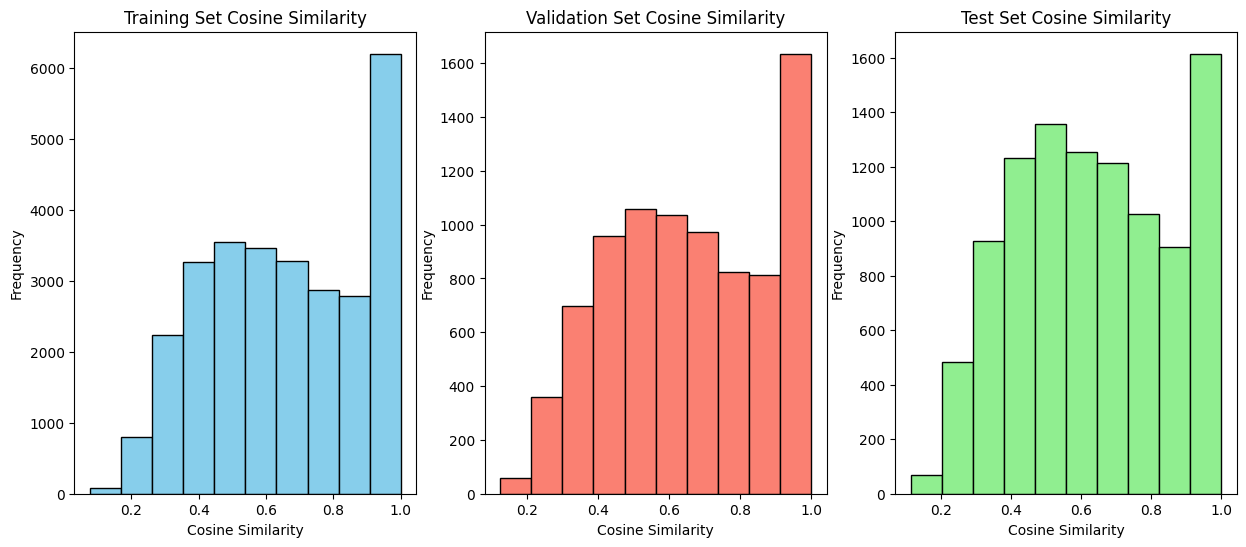

In [21]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.hist(df_train_quality['semantic_similarity'], bins=10, color='skyblue', edgecolor='black')
plt.title('Training Set Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df_validation['semantic_similarity'], bins=10, color='salmon', edgecolor='black')
plt.title('Validation Set Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df_testSet['semantic_similarity'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Test Set Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plt.show()
plt.savefig("diagram/pictures/compare_cosine_similarity.png", dpi=300)


In [ ]:
diagram/pictures